# Fake News Capstone Project Data Preparation

#### Ingestion Note: Data was originally imported from an Amazon S3 bucket that was able to hold the 32 GB file. After removing unnecessary columns and rows, the set was narrowed down to less than 5 GB. In order to run this code in a timely fashion, use the smaller dataset. 

In [1]:
#import all needed libraries and perform required configuration setup
import pandas as pd
pd.set_option('display.max_columns', 100000)
pd.set_option('display.max_row', 1000000)
import matplotlib.pyplot as plt
import numpy as np
import sys
import csv
from tqdm.autonotebook import tqdm
tqdm.pandas(desc="progress-bar")
import seaborn as sns
import s3fs
from sklearn.utils import resample

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set(style='darkgrid',palette='Dark2',rc={'figure.figsize':(9,6),'figure.dpi':100})


<ipython-input-1-80c11324ea6f>:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/Users/ellemafa/opt/anaconda3/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


### Set random seed 

In [2]:
seed = 123

### CSV field limit 
**While trying to read the dataset using pandas, there was a `csv.Error` complaining about field larger than field limit (131072)**

The csv file contain very huge fields, therefore the `field_size_limit` need to be increased. 
In order to address the error, the csv_size_limit need to be increased using the following script


In [3]:
maxInt = sys.maxsize

while True:
    # decrease the maxInt value by factor 10 
    # as long as the OverflowError occurs.

    try:
        csv.field_size_limit(maxInt)
        break
    except OverflowError:
        maxInt = int(maxInt/10)

This code above was obtained from slackoverflow blog. It can also be found on this Fake News Capstone project github https://github.com/sandgate-dev/news-content-capstone-project/blob/master/03_data_modeling.ipynb

In [4]:
#check the new field size limit
csv.field_size_limit()

9223372036854775807

## Ingest the Fake News Corpus Using chunk method

User will need to download data from Fake News Corpus - https://github.com/several27/FakeNewsCorpus/releases/tag/v1.0



In [5]:
%%time
data_chunk=pd.read_csv('/Users/ellemafa/Desktop/GTDS/FRL/news_cleaned_2018_02_13.csv', sep=',', lineterminator='\n' ,chunksize=100000)

#storing the chunks after iterating from chunk object

chunk_data=[chunk for chunk in data_chunk]

#concatnating dataframes to make it a complete dataset

df =pd.concat(chunk_data)

CPU times: user 3min, sys: 1min 18s, total: 4min 19s
Wall time: 4min 40s


In [6]:
# Delete the chunked dataframe list to release memory
#del input_data
#del chunk_data

# See what we have loaded
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8528956 entries, 0 to 8528955
Data columns (total 17 columns):
 #   Column            Dtype  
---  ------            -----  
 0   Unnamed: 0        int64  
 1   id                int64  
 2   domain            object 
 3   type              object 
 4   url               object 
 5   content           object 
 6   scraped_at        object 
 7   inserted_at       object 
 8   updated_at        object 
 9   title             object 
 10  authors           object 
 11  keywords          float64
 12  meta_keywords     object 
 13  meta_description  object 
 14  tags              object 
 15  summary           float64
 16  source            object 
dtypes: float64(2), int64(2), object(13)
memory usage: 1.1+ GB


In [7]:
len(df)

8528956

## Examining the dataset

In [8]:
# Some few rows at the begining of the dataframe
df.head(5)

,Unnamed: 0,id,domain,type,url,content,scraped_at,inserted_at,updated_at,title,authors,keywords,meta_keywords,meta_description,tags,summary,source
0,0,2,express.co.uk,rumor,https://www.express.co.uk/news/science/738402/...,"Life is an illusion, at least on a quantum lev...",2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Is life an ILLUSION? Researchers prove 'realit...,Sean Martin,NaN,[''],THE UNIVERSE ceases to exist when we are not l...,NaN,NaN,NaN
1,1,6,barenakedislam.com,hate,http://barenakedislam.com/category/donald-trum...,"Unfortunately, he hasn’t yet attacked her for ...",2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Donald Trump,"Linda Rivera, Conrad Calvano, Az Gal, Lincoln ...",NaN,[''],NaN,NaN,NaN,NaN
2,2,7,barenakedislam.com,hate,http://barenakedislam.com/category/donald-trum...,The Los Angeles Police Department has been den...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,Donald Trump,"Linda Rivera, Conrad Calvano, Az Gal, Lincoln ...",NaN,[''],NaN,NaN,NaN,NaN
3,3,8,barenakedislam.com,hate,http://barenakedislam.com/2017/12/24/more-winn...,The White House has decided to quietly withdra...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,"MORE WINNING! Israeli intelligence source, DEB...","Cleavis Nowell, Cleavisnowell, Clarence J. Fei...",NaN,[''],NaN,NaN,NaN,NaN
4,4,9,barenakedislam.com,hate,http://barenakedislam.com/2017/12/25/oh-trump-...,“The time has come to cut off the tongues of t...,2018-01-25 16:17:44.789555,2018-02-02 01:19:41.756632,2018-02-02 01:19:41.756664,"“Oh, Trump, you coward, you just wait, we will...","F.N. Lehner, Don Spilman, Clarence J. Feinour,...",NaN,[''],NaN,NaN,NaN,NaN


In [9]:
df.shape
print('The dataframe contains:', df.shape[0] ,'rows', 'and', df.shape[1], 'columns')

The dataframe contains: 8528956 rows and 17 columns


In [10]:
df.domain.value_counts()

nytimes.com                              1542685
beforeitsnews.com                         781009
dailykos.com                              660626
express.co.uk                             477264
nationalreview.com                        319556
sputniknews.com                           318745
abovetopsecret.com                        238622
wikileaks.org                             199031
www.newsmax.com                           107420
pravda.ru                                  95141
www.ammoland.com                           92846
wikispooks.com                             80683
lifezette.com                              76999
investmentwatchblog.com                    68559
dailycaller.com                            66706
breitbart.com                              60436
thepostemail.com                           59236
rawstory.com                               58659
naturalnews.com                            56383
pjmedia.com                                52642
thedailysheeple.com 

## How many domains per type?

In [18]:
df.groupby('type')['domain'].nunique().reset_index()

,type,domain
0,bias,95
1,clickbait,21
2,conspiracy,84
3,fake,107
4,hate,15
5,junksci,24
6,political,55
7,reliable,80
8,rumor,5
9,satire,78


## Count of types per domain

In [12]:
df.pivot_table(index='domain', 
               columns='type',
               aggfunc='size',
               fill_value=0)

type,bias,clickbait,conspiracy,fake,hate,junksci,political,reliable,rumor,satire,unknown,unreliable
domain,,,,,,,,,,,,
100percentfedup.com,97,0,0,0,0,0,0,0,0,0,0,0
16wmpo.com,0,0,0,1,0,0,0,0,0,0,0,0
21stcenturywire.com,0,0,19897,0,0,0,0,0,0,0,0,0
4threvolutionarywar.wordpress.com,5394,0,0,0,0,0,0,0,0,0,0,0
70news.wordpress.com,0,0,0,2294,0,0,0,0,0,0,0,0
82.221.129.208,0,0,32,0,0,0,0,0,0,0,0,0
Newsmax.com,0,0,0,0,0,0,0,0,0,0,0,1
NoMoreFakeNews.com,0,0,2,0,0,0,0,0,0,0,0,0
Zengardner.com,0,0,0,0,0,0,0,0,0,0,1,0


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8528956 entries, 0 to 8528955
Data columns (total 17 columns):
 #   Column            Dtype  
---  ------            -----  
 0   Unnamed: 0        int64  
 1   id                int64  
 2   domain            object 
 3   type              object 
 4   url               object 
 5   content           object 
 6   scraped_at        object 
 7   inserted_at       object 
 8   updated_at        object 
 9   title             object 
 10  authors           object 
 11  keywords          float64
 12  meta_keywords     object 
 13  meta_description  object 
 14  tags              object 
 15  summary           float64
 16  source            object 
dtypes: float64(2), int64(2), object(13)
memory usage: 1.1+ GB


The data contains 17 columns and about 9 million rows.     From the  original repo `README`, the columns `type` and `tags` are the same because they represent the same classification of the content

### Checking the missing values 

In [14]:
def missing_value(df):
    """" Function to calculate the number and percent of missing values in a dataframe"""
    total = df.isnull().sum().sort_values(ascending=False)
    percent = ((df.isnull().sum()/df.isnull().count())*100).sort_values(ascending=False)
    missing_value = pd.concat([total, percent], axis=1, keys=['Total','Percent'])
    return missing_value

In [15]:
# check and print out the missing values in the data
missing_value(df)

,Total,Percent
keywords,8528956,100.000000
summary,8528956,100.000000
source,6648362,77.950478
tags,6560408,76.919238
meta_description,4481821,52.548295
authors,3791514,44.454609
type,403211,4.727554
meta_keywords,337909,3.961903
title,73221,0.858499
url,0,0.000000


#### Observations from initial exploration of the data

1. Lot of missing values
2. the `domain` and `url` columns seems to present the same thing. If you look at the README in the Fake News Corpus repo. Domain should be more useful


## Suggestions on selecting columns that are necessary for our model 

**The following columns can be excluded from the datasets with reasons**
1. All the columns with greater than 50% of missing values : `source` , `summary` , `keywords` , `meta_description`
2. The `url` column because it kind of duplicated the `domain` column plus it also contains a lot of missing values
3. The `id` and `Unamed: 0` columns because they are just index of the dataframe and will not contribute anything to our model
4. The dates `scraped_at` , `updated_at` and `inserted_at` columns does not seem to be useful at all because the range covers just one day or two days at most

## Dropping the unnecessay columns

In [19]:
# list of columns to drop from the datasets
cols_to_drop = ['authors','id','Unnamed: 0', 'url', 'source', 'summary', 'keywords','meta_keywords','tags', 'meta_description','scraped_at','updated_at', 'inserted_at']

In [20]:
# drop the columns and check the memory usage
df.drop(cols_to_drop, axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8528956 entries, 0 to 8528955
Data columns (total 4 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   domain   object
 1   type     object
 2   content  object
 3   title    object
dtypes: object(4)
memory usage: 260.3+ MB


In [21]:
# The first 5 rows of the new dataframe
df.head()

,domain,type,content,title
0,express.co.uk,rumor,"Life is an illusion, at least on a quantum lev...",Is life an ILLUSION? Researchers prove 'realit...
1,barenakedislam.com,hate,"Unfortunately, he hasn’t yet attacked her for ...",Donald Trump
2,barenakedislam.com,hate,The Los Angeles Police Department has been den...,Donald Trump
3,barenakedislam.com,hate,The White House has decided to quietly withdra...,"MORE WINNING! Israeli intelligence source, DEB..."
4,barenakedislam.com,hate,“The time has come to cut off the tongues of t...,"“Oh, Trump, you coward, you just wait, we will..."


In [22]:
# Checking for null values
missing_value(df)

,Total,Percent
type,403211,4.727554
title,73221,0.858499
content,0,0.000000
domain,0,0.000000


## Checking the number of unique values in the type column

In [23]:
df['type'].value_counts(dropna=False, ascending=False)

reliable      1913222
political     1657224
bias          1138998
fake           894746
conspiracy     831235
rumor          481158
NaN            403211
unknown        371518
unreliable     298784
clickbait      231949
junksci        117467
satire         112948
hate            76496
Name: type, dtype: int64

### From the metadata provided on the Fake News Corpus repo. 

1. `rumor` is not among the classes specified in the `type` or `tags` column
2. We can drop the two classes `rumor` and `unknown` 
3. The group decided that we will only be using two classes `reliable` and `fake`
4. We will drop the other unneeded classes
5. We can recode the remaining two class to binary containing only `real` and `fake` news class

### Dropping all the unneeded classes 

In [24]:
df = df[df['type'].isin(['fake', 'reliable'])].reset_index(drop=True)

In [24]:
#use this block if any parsing isssues occured on ingest that caused date values to be in the "type" field

# list of classes in the type column that need to be dropped
#classes_to_drop = ['2018-02-10 13:43:39.521661','rumor','bias','political','conspiracy','unknown','clickbait','junksci','satire','unreliable','hate']

# Getting the indexes for the classes
#index_names = df[ df['type'].isin(classes_to_drop)].index 

# dropping the rows based on the column indexes
#df.drop(index_names, inplace = True) 

In [25]:
df['type'].value_counts(dropna=False, ascending=False)

reliable    1913222
fake         894746
Name: type, dtype: int64

In [26]:
len(df)

2807968

In [27]:
df.shape
print('The dataframe contains:', df.shape[0] ,'rows', 'and', df.shape[1], 'columns')

The dataframe contains: 2807968 rows and 4 columns


## Rename  binary class in type column to fake and real

In [28]:
#replace the class
df['type'] = df['type'].replace('reliable', 'real')

# check the column values again
df['type'].value_counts(dropna=False, ascending=False)

real    1913222
fake     894746
Name: type, dtype: int64

In [29]:
#Check the remaining missing values
missing_value(df)

,Total,Percent
title,13,0.000463
content,0,0.000000
type,0,0.000000
domain,0,0.000000


In [30]:
# there are missing values in the title field, lets remove these as it can affect proceeding NLP preprprocessing
df = df.dropna().reset_index(drop=True)
missing_value(df)

,Total,Percent
title,0,0.0
content,0,0.0
type,0,0.0
domain,0,0.0


## Visualize the type column

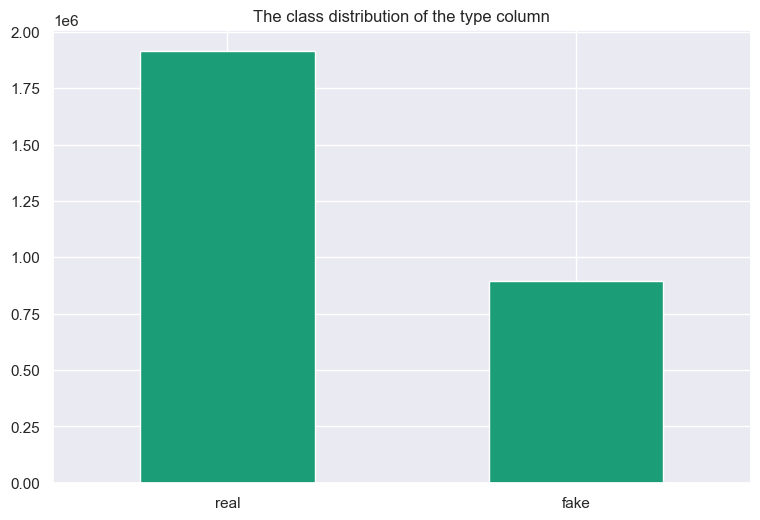

In [31]:
df['type'].value_counts(dropna=False, ascending=False).plot.bar(rot=0, title='The class distribution of the type column');

#### There is a class imbalance which will create a bias in the model training. We need to Down sample the majority class

### Down-sampling involves randomly removing observations from the majority class to prevent its signal from dominating the learning algorithm.

The most common heuristic for doing so is resampling without replacement.

The process is similar to that of up-sampling. Here are the steps:

First, we'll separate observations from each class into different DataFrames. Next, we'll resample the majority class without replacement, setting the number of samples to match that of the minority class. Finally, we'll combine the down-sampled majority class DataFrame with the original minority class DataFrame.

In [32]:
#Separate majority and minority classes
majority = df[df.type=='real']
minority = df[df.type=='fake']

# Downsample majority class
majority_downsampled = resample(majority, 
                                replace=False, # sample without replacement
                                n_samples=len(minority), # to match minority class
                                random_state=seed) # reproducible results

# Combine minority class with downsampled majority class
df = pd.concat([majority_downsampled, minority])

# Display new class counts
df['type'].value_counts()


fake    894737
real    894737
Name: type, dtype: int64

In [33]:
#delete temp dataframe to free up memory
del majority
del minority
del majority_downsampled

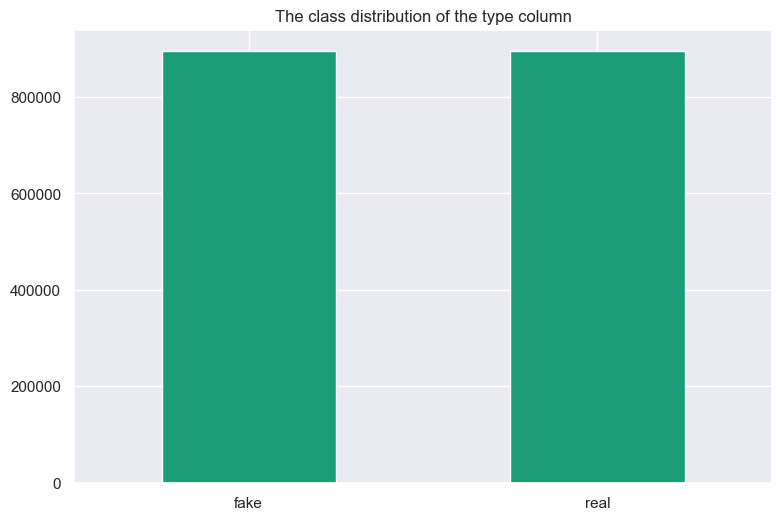

In [34]:
df['type'].value_counts(dropna=False, ascending=False).plot.bar(rot=0, title='The class distribution of the type column');

In [35]:
df.groupby('type')['domain'].nunique().reset_index()

,type,domain
0,fake,106
1,real,80


In [36]:
df.pivot_table(index='domain', 
               columns='type',
               aggfunc='size',
               fill_value=0)

type,fake,real
domain,,
16wmpo.com,1,0
70news.wordpress.com,2294,0
abcnews.go.com,0,4098
af.reuters.com,0,2526
americannews.com,197,0
americanoverlook.com,47,0
anonjekloy.tk,38,0
au.be.yahoo.com,0,336
au.finance.yahoo.com,0,510


In [37]:
df.head(5)

,domain,type,content,title
2028148,nytimes.com,real,The stunning announcement by Japanese and Amer...,Behind the Stem Cell Breakthrough
2417229,nytimes.com,real,We are halfway between the lunatic and the ter...,Quotation of the Day
1701212,nytimes.com,real,There were Jews in Manhattan before there was ...,Celebrating Sounds Rooted In Gritty but Fertil...
2426955,nytimes.com,real,To the Editor:\n\n“How Apple Sidesteps Billion...,"What Apple Pays in Taxes, and Doesn't"
1487266,nytimes.com,real,"Katharine Winnifred Shergalis, a daughter of M...","Katharine Shergalis, Thomas Ewald"


## Saving the dataframe to s3 bucket

In [38]:
#s3 = s3fs.S3FileSystem(anon=False) # publicly-available,  # uses default credentials

#with s3.open('osanusi-auto/capstone_prep2021.csv','w') as f:
#    df.to_csv(f, index=False)

## Saving the dataframe to csv

In [38]:
df.to_csv("./FRL_Step_1_news_cleaned_2018_02_13.csv", sep=',',index=False)